# Local Linear Regression with Kernel Smoothing

Local Linear Regression (LLR) is a non-parametric regression method that uses a locally weighted linear model to estimate the function at a particular point. It fits a linear model to each point in a local neighborhood, and the weights for the local points are determined by a kernel function.

## Mathematical Background

Given a data set $(x_1, y_1), (x_2, y_2), \ldots, (x_n, y_n)$, the estimate $ \hat{f}(x_0) $ of the regression function $ f $ at the point $ x_0 $ is given by:

$ \hat{f}(x_0) = \hat{\beta}_0 + \hat{\beta}_1 x_0 $

Where $ \hat{\beta}_0 $ and $ \hat{\beta}_1 $ are the coefficients of the local linear model, found by minimizing:

$ \sum_{i=1}^{n} K_h(x_0 - x_i) [y_i - (\beta_0 + \beta_1 x_i)]^2 $

Here, $ K_h $ is a kernel function with bandwidth $ h $. In our implementation, we use the Gaussian kernel:

$ K_h(z) = \frac{1}{\sqrt{2\pi}} e^{-\frac{z^2}{2h^2}} $

The weights for each data point in the local neighborhood of $ x_0 $ are given by the values of the kernel function, evaluated at the distance between $ x_0 $ and each data point, scaled by the bandwidth $ h $.

## Python Implementation

The implementation uses numpy for array operations and matrix computations. The method `local_linear_regression` is defined to compute the estimate of the function at any point `x0`. The method uses the Gaussian kernel function to determine the weights of the local data points and fits a weighted linear model to estimate the function.

The performance of the LLR is evaluated using leave-one-out cross-validation over a range of bandwidth values. The mean squared error for each bandwidth is computed and plotted. The bandwidth that minimizes this error is then considered the optimal bandwidth for the LLR.

<b>Reference:</b> From GaTech ISYE 8803 High Dimensional Data Analytics lecture notes, enhanced with ChatGPT.

Optimal bandwidth h: 0.03


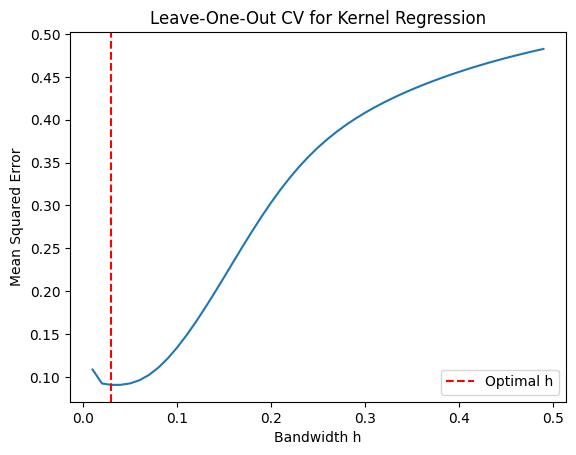

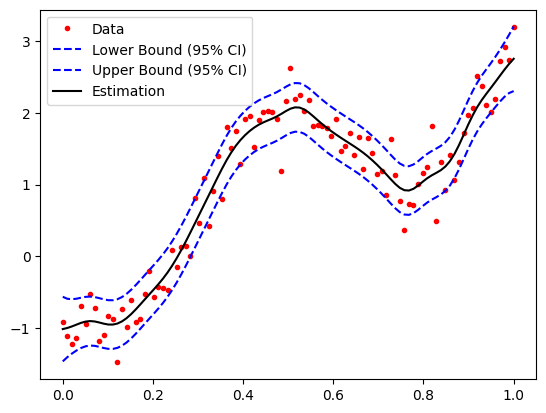

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation
n = 100
D = np.linspace(0, 1, n)
sigma = 0.3
fun = lambda x: 2.5 * x - np.sin(10 * x) - np.exp(-10 * x)
y = fun(D) + np.random.randn(n) * sigma

# Gaussian kernel function
kerf = lambda z: np.exp(-z**2 / 2) / np.sqrt(2 * np.pi)

# Local linear regression prediction
def local_linear_regression(x0, X, Y, h):
    weights = kerf((x0 - X) / h)
    
    W = np.diag(weights)
    b = np.array([np.ones_like(X), X]).T
    beta = np.linalg.solve(b.T @ W @ b, b.T @ W @ Y)
    
    return beta[0] + beta[1] * x0

# Leave-one-out CV
h_values = np.arange(0.01, 0.5, 0.01)
mse = []

for h in h_values:
    errors = []
    for i in range(n):
        mask = np.ones(n, bool)
        mask[i] = 0
        X1, Y1 = D[mask], y[mask]
        
        y_hat = local_linear_regression(D[i], X1, Y1, h)
        error = y[i] - y_hat
        errors.append(error)
    
    mse.append(np.mean(np.array(errors)**2))

# Optimal bandwidth
h_optimal = h_values[np.argmin(mse)]
print("Optimal bandwidth h:", h_optimal)

# Plotting
plt.plot(h_values, mse)
plt.axvline(x=h_optimal, color='red', linestyle='--', label='Optimal h')
plt.xlabel('Bandwidth h')
plt.ylabel('Mean Squared Error')
plt.title('Leave-One-Out CV for Kernel Regression')
plt.legend()
plt.show()

# Kernel regression estimate using optimal bandwidth
yhat_best = np.zeros(n)
for i in range(n):
    z = kerf((D - D[i]) / h_optimal)
    yhat_best[i] = np.sum(z * y) / np.sum(z)

# Calculate 95% confidence intervals
alpha = 0.05
z_val = np.abs(np.percentile(np.random.randn(10000), 100*(1-alpha/2)))  # z-value for 95% confidence
stderr = sigma / np.sqrt(np.sum(kerf((D - D[:, np.newaxis]) / h_optimal), axis=1))
yn = yhat_best - z_val * stderr
yp = yhat_best + z_val * stderr

# Plot function
plt.plot(D, y, 'r.', label='Data')
plt.plot(D, yn, 'b--', label='Lower Bound (95% CI)')
plt.plot(D, yp, 'b--', label='Upper Bound (95% CI)')
plt.plot(D, yhat_best, 'k-', label='Estimation')
plt.legend()
plt.show()
